In [2]:
import arviz as az
import pymc as pm
# import arviz.labels as azl

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import matplotlib as mpl
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

## Reestimate model because of pickle problems

In [12]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_gp(y, X, l_prior, eta_prior, sigma_prior, kernel_type='M52', bayes_kws=dict(draws=1000, tune=1000, chains=2, cores=1), prop_Xu=None):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use. If None, use full marginal likelihood. If not none, use FTIC. 
    bayes_kw : kws for pm.sample
    X, y are dataframes. We'll use the column names. 
    """
    kernel_type = kernel_type.lower()
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values.flatten()
        X_cols = list(X.columns)

        
        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 
        
        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Model
        if not (prop_Xu is None):
            # Inducing variables
            num_Xu = int(X_a.shape[0]*prop_Xu)
            Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)
            gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, Xu=Xu, noise=sigma_n)
        else:
            gp = pm.gp.Marginal(cov_func=cov_tot)
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        
        if not (bayes_kws is None):
            trace = pm.sample(**bayes_kws)
            result = trace
        else:
            mp = pm.find_MAP(progressbar=False)
            result = mp
    
    return gp, result, model

def bootstrap(n_samples,y, X, seed=42, **kwargs):
    rng = np.random.default_rng(seed)
    all_params = []
    all_preds = []
    i = 0
    while i < n_samples:
        print(' ', i, end=', ')
        ix = np.array(y.index)
        bs_ix = rng.choice(ix, size=len(ix), replace=True)
        new_y, new_X = y.loc[bs_ix, :], X.loc[bs_ix, :]
        try: 
            gp, mp, model = fit_gp(new_y, new_X, **kwargs)
            all_params.append(mp)
            with model:
                y_pred, var = gp.predict(new_X.values, point=mp, diag=True)
                all_preds.append((new_y, y_pred, var))
            i += 1
            
        except: 
            print('error')

    print()

    return all_params, all_preds
        

In [14]:
root_path = '1fme/sensitivity'
experiments = [['dihedrals', None, 'exponential'], ['distances', 'linear', 'exponential'], ['distances', 'logistic', 'exponential']]
models = []

l_prior = gamma(2, 0.5)
eta_prior = hcauchy(2)
sigma_prior = hcauchy(2)

params = []
preds = []
n_boot = 250

for i, (feat, trans, kernel) in enumerate(experiments):
    print(feat, trans, kernel)
    kwargs = dict(l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                  kernel_type=kernel,  # Kernel
                  prop_Xu=None,  # proportion of data points which are inducing variables.
                  bayes_kws=None)    
    results_path = Path(root_path).joinpath(f"{feat}_{trans}_{kernel}_mml.pkl")

    results = pickle.load(results_path.open('rb'))
    data_s = results['data']
    y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]
    
    param, pred = bootstrap(n_boot, y, X, **kwargs)
    params.append(param)
    preds.append(pred)

dihedrals None exponential
  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,   100,   101,   102,   103,   104,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,   115,   116,   117,   118,   119,   120,   121,   122,   123,   124,   125,   126,   127,   128,   129,   130,   131,   132,   133,   134,   135,   136,   137,   138,   139,   140,   141,   142,   143,   144,   145,   146,   147,   148,   149,   150,   151,   152,   153,   154

In [28]:
param_df = []
keep_params = ['l_dim', 'l_lag', 'l_states', 'feature', 'l_cent', 'l_steep']

for i, experiment in enumerate(experiments): 
    bs_params = params[i]
    lab = experiment[0]
    if experiment[1] is not None: 
        lab += f"-{experiment[1]}"
    df = pd.concat([pd.DataFrame(x, index=[j]) for j, x in enumerate(bs_params)])
    df['feature'] = lab    
    param_df.append(df)
    
param_df = pd.concat(param_df)
param_df = param_df.loc[:, keep_params]
param_df_m = param_df.melt(id_vars=['feature'], var_name='hyperparameter')
param_df_m['R'] = 1.0/param_df_m['value']

var_name_map={"l_states": r"Num. states", 
            "l_dim": r"Num. dims", 
            "l_lag": r"$\tau_{tICA}$", 
            "l_cent": r"Centre", 
             "l_steep": r"Steepness"}

param_df_m['hyperparameter'] = param_df_m['hyperparameter'].apply(lambda x: var_name_map[x])

Sensitivity

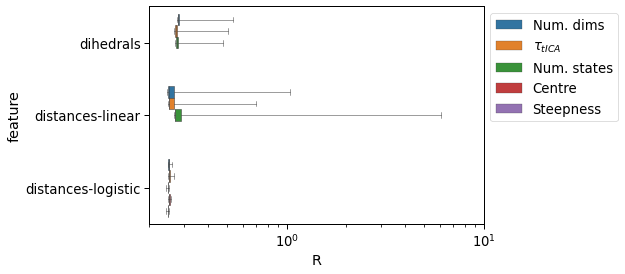

In [36]:
with sns.plotting_context('paper', font_scale=1.5): 
    fig, ax = plt.subplots(1)
    sns.boxplot(y='feature', x='R', hue='hyperparameter', data=param_df_m,ax=ax, 
               whis=(0, 100), orient='h', linewidth=0.5)
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, l, loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_xlim(0.2, 10)
    ax.set_xscale('log')
    plt.savefig(Path(root_path).parent.joinpath('sensitivity.pdf'), bbox_inches='tight')
    